<a href="https://colab.research.google.com/github/HoangHungLN/MachineLearning_Assignment/blob/main/Assignment3/notebooks/Assignment3_CEML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vì tổng dung lượng của thư mục ảnh là rất lớn nên nhóm sử dụng lfs của git để lưu trữ ảnh, khi chạy chương trình sẽ clone trực tiếp đến github của nhóm và pull dữ liệu lfs về để sử dụng cho quá trình thực hiện pipeline.

In [1]:
#Khởi tạo và import thư viện
!git clone https://github.com/HoangHungLN/MachineLearning_Assignment.git
!cd MachineLearning_Assignment && git lfs pull

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

fatal: destination path 'MachineLearning_Assignment' already exists and is not an empty directory.


In [2]:
#Đường dẫn đến thư mục ảnh, và file chứa nhãn
base_dir = "MachineLearning_Assignment/Assignment3/data"
csv_path = os.path.join(base_dir, "Training_set.csv")
image_dir = os.path.join(base_dir, "HumanActionDataset")

Số lượng mẫu (số lượng ảnh): 12600

 Bảng thống kê số lượng ảnh cho mỗi lớp:

| Lớp                |   Số lượng ảnh |
|:-------------------|---------------:|
| sitting            |            840 |
| using_laptop       |            840 |
| hugging            |            840 |
| sleeping           |            840 |
| drinking           |            840 |
| clapping           |            840 |
| dancing            |            840 |
| cycling            |            840 |
| calling            |            840 |
| laughing           |            840 |
| eating             |            840 |
| fighting           |            840 |
| listening_to_music |            840 |
| running            |            840 |
| texting            |            840 |




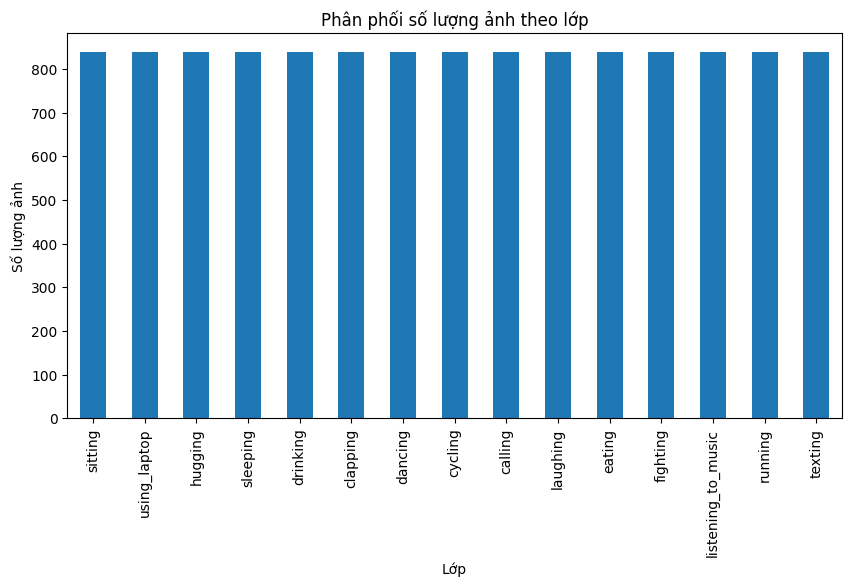

In [3]:
#Đọc file csv để thống kê số lượng mẫu
df = pd.read_csv(csv_path)
print("Số lượng mẫu (số lượng ảnh):", len(df))

#Bảng thống kê số lượng ảnh cho mỗi lớp
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Lớp', 'Số lượng ảnh']
print("\n Bảng thống kê số lượng ảnh cho mỗi lớp:\n")
print(label_counts.to_markdown(index=False))
print("\n")

#Thống kê phân phối nhãn
plt.figure(figsize=(10,5))
df['label'].value_counts().plot(kind='bar')
plt.title("Phân phối số lượng ảnh theo lớp")
plt.xlabel("Lớp")
plt.ylabel("Số lượng ảnh")
plt.show()

##Thống kê số lượng ảnh cho mỗi lớp và phân phối nhãn
###Số lượng ảnh cho mỗi lớp
Tập dữ liệu gồm 12600 ảnh hoạt động của con người, chia đều cho 15 nhãn phân loại tương ứng với 15 loại hoạt động thường ngày.

Mỗi lớp phân loại gồm 840 ảnh. Cho thấy tập dữ liệu được thiết kế đồng đều và có quy mô phù hợp cho việc huấn luyện các mô hình học máy.
###Phân phối nhãn
Quan sát từ bảng thống kê và biểu đồ phân phối số lượng ảnh theo lớp, ta nhận thấy:

- Mỗi lớp có số lượng mẫu bằng nhau (840 ảnh).

- Không có lớp nào chiếm ưu thế vượt trội, nên tập dữ liệu hoàn toàn cân bằng.

Điều này là rất lý tưởng trong học máy, vì mô hình sẽ không bị thiên vị (bias) về phía một lớp cụ thể.
Bên cạnh đó, việc các lớp được phân bố đồng đều giúp mô hình học được đặc trưng của từng loại hoạt động một cách công bằng, từ đó giảm nguy cơ overfitting hoặc under-representation.

In [4]:
# Thốngg kê kích thước ảnh
widths, heights, channels = [], [], []

for fname in df['filename'][:500]:
    fpath = os.path.join(image_dir, fname)
    if os.path.exists(fpath):
        with Image.open(fpath) as img:
            w, h = img.size
            c = len(img.getbands())
            widths.append(w)
            heights.append(h)
            channels.append(c)

stats_df = pd.DataFrame({
    "width": widths,
    "height": heights,
    "channels": channels
})


print("\nThống kê kích thước ảnh:")
print(stats_df.describe())

print("\nSố kênh màu:")
print(stats_df['channels'].value_counts())


Thống kê kích thước ảnh:
            width      height  channels
count  500.000000  500.000000     500.0
mean   260.646000  195.020000       3.0
std     42.399435   35.619448       0.0
min     84.000000   84.000000       3.0
25%    259.000000  181.000000       3.0
50%    275.000000  183.000000       3.0
75%    276.000000  194.000000       3.0
max    399.000000  300.000000       3.0

Số kênh màu:
channels
3    500
Name: count, dtype: int64


## Thống kê kích thước và kênh màu của ảnh
Vì số lượng ảnh là rất lớn nên nhóm không thể chạy thống kê cho toàn bộ tập dữ liệu, nhóm chỉ thống kê trên 500 ảnh mẫu đại diện cho tập dữ liệu nhằm tiết kiệm thời gian xử lý mà vẫn cung cấp được cái nhìn rõ hơn về tập dữ liệu.
### Kích thước ảnh
Tập dữ liệu được thống kê trên 500 ảnh mẫu cho thấy:
- Chiều rộng trung bình khoảng 260 pixel
- Chiều cao trung bình khoảng 195 pixel
- Kích thước ảnh dao động khá linh hoạt

Điều này cho thấy các ảnh trong tập dữ liệu không đồng nhất về kích thước, có thể do được thu thập từ nhiều nguồn khác nhau hoặc chưa qua bước tiền xử lý chuẩn hoá. Trước khi huấn luyện mô hình học máy, cần resize tất cả ảnh về cùng kích thước chuẩn.

### Số kênh màu
Tất cả 500 ảnh đều có 3 kênh màu (RGB).
Điều này chứng tỏ tập dữ liệu chỉ bao gồm ảnh màu, không có ảnh grayscale hay định dạng khác. Như vậy, mô hình có thể khai thác đầy đủ thông tin màu sắc để học các đặc trưng liên quan đến hành động
(ví dụ: quần áo, bối cảnh, vật thể).

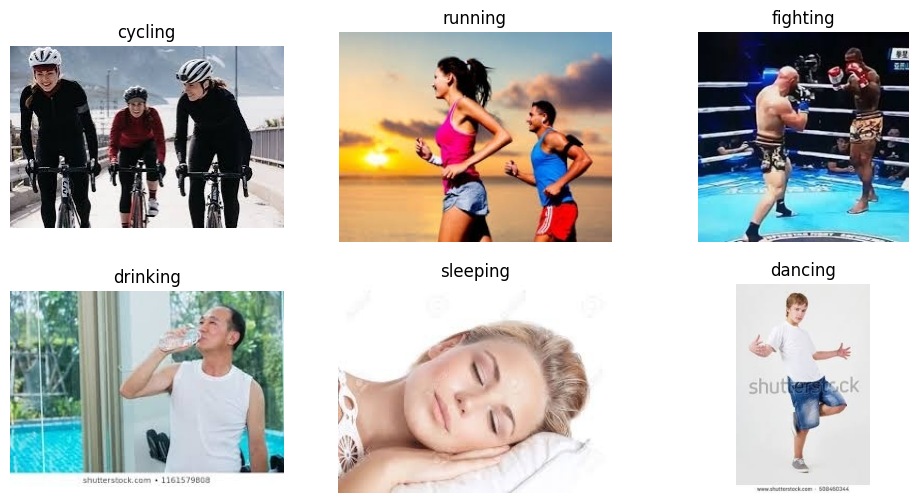

In [5]:
#Hiển thị vài ảnh mẫu
sample_imgs = df.sample(6, random_state=42)
plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_imgs.itertuples()):
    img_path = os.path.join(image_dir, row.filename)
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")
plt.show()

##Tiền xử lý

Hàm `preprocessing()` chịu trách nhiệm thực hiện toàn bộ bước **tiền xử lý dữ liệu ảnh** trước khi đưa vào mô hình học máy. Cụ thể, hàm đọc thông tin ảnh và nhãn từ file CSV, chuyển đổi nhãn về dạng số, tạo đường dẫn tuyệt đối cho từng ảnh và chia dữ liệu thành ba tập: **train**, **validation** và **test** theo tỷ lệ định sẵn.  

Trong quá trình xử lý, mỗi ảnh được đọc từ ổ đĩa, giải mã, **resize** về kích thước chuẩn (224*224), sau đó **chuẩn hóa giá trị pixel** bằng hàm `preprocess_input` tương ứng với mô hình pretrained được chọn (VGG16, ResNet50 hoặc EfficientNetB0).  

Cuối cùng, dữ liệu được tổ chức dưới dạng **`tf.data.Dataset`** - một pipeline tối ưu cho TensorFlow, bao gồm các thao tác **batch**, **shuffle** và **prefetch** nhằm tăng tốc độ huấn luyện. Hàm trả về ba tập dữ liệu (`train_ds`, `val_ds`, `test_ds`) cùng với danh sách tên lớp (`class_names`), sẵn sàng cho bước trích xuất đặc trưng và huấn luyện mô hình.


In [6]:
from MachineLearning_Assignment.Assignment3.modules.preprocessor import preprocessing
from MachineLearning_Assignment.Assignment3.modules.feature_extractor import run_extraction

In [7]:
# # 4. Chạy pipeline trích xuất đặc trưng cho ResNet50
# print("--- Đang xử lý: ResNet50 ---")

# # 4.1. Tạo pipeline dữ liệu (chuẩn hóa cho ResNet50)
# train_ds_resnet, val_ds_resnet, test_ds_resnet, class_names = preprocessing(
#     image_dir=image_dir,
#     csv_path=csv_path,
#     model_name="ResNet50",
#     image_size=(224, 224),
#     batch_size=64, val_split=0.1, test_split=0.1
# )

# resnet_pipeline = {"train": train_ds_resnet, "val": val_ds_resnet, "test": test_ds_resnet}

# # 4.2. Chạy trích xuất và lưu file .npy
# run_extraction(
#     model_name="resnet50",
#     data_pipeline=resnet_pipeline,
#     output_dir="features_output/resnet50"
# )
# print("--- Hoàn thành: ResNet50 ---")

# del train_ds_resnet, val_ds_resnet, test_ds_resnet, resnet_pipeline

In [8]:
# # # 5. Chạy pipeline trích xuất đặc trưng cho VGG16
# # print("\n--- Đang xử lý: VGG16 ---")

# # # 5.1. Tạo pipeline dữ liệu (chuẩn hóa cho VGG16)
# # train_ds_vgg, val_ds_vgg, test_ds_vgg, _ = preprocessing(
# #     image_dir=image_dir,
# #     csv_path=csv_path,
# #     model_name="VGG16",
# #     image_size=(224, 224),
# #     batch_size=64, val_split=0.1, test_split=0.1
# # )
# # vgg_pipeline = {"train": train_ds_vgg, "val": val_ds_vgg, "test": test_ds_vgg}

# # # 5.2. Chạy trích xuất và lưu file .npy
# # run_extraction(
# #     model_name="vgg16",
# #     data_pipeline=vgg_pipeline,
# #     output_dir="features_output/vgg16"
# # )
# # print("--- Hoàn thành: VGG16 ---")

# del train_ds_vgg, val_ds_vgg, test_ds_vgg, vgg_pipeline

In [9]:
# # 6. Chạy pipeline trích xuất đặc trưng cho EfficientNetB0
# print("\n--- Đang xử lý: EfficientNetB0 ---")

# # 6.1. Tạo pipeline dữ liệu (chuẩn hóa cho EfficientNetB0)
# train_ds_eff, val_ds_eff, test_ds_eff, _ = preprocessing(
#     image_dir=image_dir,
#     csv_path=csv_path,
#     model_name="EfficientNetB0",
#     image_size=(224, 224),
#     batch_size=64, val_split=0.1, test_split=0.1
# )
# eff_pipeline = {"train": train_ds_eff, "val": val_ds_eff, "test": test_ds_eff}

# # 6.2. Chạy trích xuất và lưu file .npy
# run_extraction(
#     model_name="efficientnetb0",
#     data_pipeline=eff_pipeline,
#     output_dir="features_output/efficientnetb0"
# )
# print("--- Hoàn thành: EfficientNetB0 ---")

In [10]:
import numpy as np

resnet50_features_dir = "MachineLearning_Assignment/Assignment3/features_output/resnet50"
effectientnetb0_features_dir = "MachineLearning_Assignment/Assignment3/features_output/efficientnetb0"
vgg16_features_dir = "MachineLearning_Assignment/Assignment3/features_output/vgg16"

X_resnet_train = np.load(f"{resnet50_features_dir}/X_train.npy")
y_resnet_train = np.load(f"{resnet50_features_dir}/y_train.npy")
X_resnet_val = np.load(f"{resnet50_features_dir}/X_val.npy")
y_resnet_val = np.load(f"{resnet50_features_dir}/y_val.npy")
X_resnet_test = np.load(f"{resnet50_features_dir}/X_test.npy")
y_resnet_test = np.load(f"{resnet50_features_dir}/y_test.npy")

X_effectientnet_train = np.load(f"{effectientnetb0_features_dir}/X_train.npy")
y_effectientnet_train = np.load(f"{effectientnetb0_features_dir}/y_train.npy")
X_effectientnet_val = np.load(f"{effectientnetb0_features_dir}/X_val.npy")
y_effectientnet_val = np.load(f"{effectientnetb0_features_dir}/y_val.npy")
X_effectientnet_test = np.load(f"{effectientnetb0_features_dir}/X_test.npy")
y_effectientnet_test = np.load(f"{effectientnetb0_features_dir}/y_test.npy")

X_vgg_train = np.load(f"{vgg16_features_dir}/X_train.npy")
y_vgg_train = np.load(f"{vgg16_features_dir}/y_train.npy")
X_vgg_val = np.load(f"{vgg16_features_dir}/X_val.npy")
y_vgg_val = np.load(f"{vgg16_features_dir}/y_val.npy")
X_vgg_test = np.load(f"{vgg16_features_dir}/X_test.npy")
y_vgg_test = np.load(f"{vgg16_features_dir}/y_test.npy")



In [11]:
import numpy as np

# Tổng số mẫu (train/val/test & all)
n_tr, n_va, n_te = len(y_vgg_train), len(y_vgg_val), len(y_vgg_test)
n_all = n_tr + n_va + n_te

# Số lớp
num_classes1 = int(np.max([y_effectientnet_train.max(), y_effectientnet_val.max(), y_effectientnet_test.max()])) + 1
num_classes2 = int(np.max([y_vgg_train.max(), y_vgg_val.max(), y_vgg_test.max()])) + 1
num_classes3 = int(np.max([y_resnet_train.max(), y_resnet_val.max(), y_resnet_test.max()])) + 1

# Phân bố theo lớp
def count_per_class(y):
    return np.bincount(y, minlength=num_classes3)


print("Num classes:", num_classes2)
print(f"Sizes  -> train:{n_tr}  val:{n_va}  test:{n_te}  total:{n_all}")
print("Train per-class:", count_per_class(y_vgg_train))
print("Val   per-class:", count_per_class(y_vgg_val))
print("Test  per-class:", count_per_class(y_vgg_test))



Num classes: 15
Sizes  -> train:10080  val:1260  test:1260  total:12600
Train per-class: [672 672 672 672 672 672 672 672 672 672 672 672 672 672 672]
Val   per-class: [84 84 84 84 84 84 84 84 84 84 84 84 84 84 84]
Test  per-class: [84 84 84 84 84 84 84 84 84 84 84 84 84 84 84]


In [24]:
model_params = {
    # 1) RandomForest
    "RandomForest": [
        {"n_estimators": 200, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1, "criterion": "gini", "max_features": "sqrt"},
        {"n_estimators": 100, "max_depth": 30,   "min_samples_split": 2, "min_samples_leaf": 2, "criterion": "entropy", "max_features": "log2"},
        {"n_estimators": 200, "max_depth": 20,   "min_samples_split": 2, "min_samples_leaf": 3, "criterion": "gini", "max_features": "sqrt"},
    ],

    # 2) Logistic Regression  (nên kèm StandardScaler trong pipeline)
    "LogisticRegression": [
        {"C": 0.1, "penalty": "l2", "solver": "lbfgs", "max_iter": 2000, "multi_class": "multinomial", "n_jobs": -1},
        {"C": 0.1, "penalty": "elasticnet", "solver": "saga", "max_iter": 2000, "n_jobs": -1, "l1_ratio":0.5},

        {"C": 2.0, "penalty": "l2", "solver": "lbfgs", "max_iter": 2000, "n_jobs": -1},
        {"C": 1.0, "penalty": "l2", "solver": "lbfgs", "max_iter": 1000, "n_jobs": -1},
        {"C": 4.0, "penalty": "l2", "solver": "lbfgs", "max_iter": 1000, "n_jobs": -1}
    ],

    "LinearSVC": [
        {"C": 3.0, "loss": "hinge",           "dual": True, "max_iter": 1000},
        {"C": 1.0, "max_iter": 8000},
        {"C": 2.5,"max_iter": 8000}
    ],

    # 4) Kernel SVM (SVC) — mạnh nhưng chậm; nhớ scale trước
    "SVC": [
        {"kernel": "rbf",    "C": 1.0, "gamma": "scale", "probability": False},
        {"kernel": "rbf",    "C": 3.0, "gamma": 0.1,      "probability": True},
    ],
}

In [13]:
!wget https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assignment/refs/heads/main/Assignment3/modules/run_model.py -O MachineLearning_Assignment/Assignment3/modules/run_model.py

--2025-11-03 22:09:58--  https://raw.githubusercontent.com/HoangHungLN/MachineLearning_Assignment/refs/heads/main/Assignment3/modules/run_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3931 (3.8K) [text/plain]
Saving to: ‘MachineLearning_Assignment/Assignment3/modules/run_model.py’

MachineLearning_Ass 100%[===================>]   3.84K  --.-KB/s    in 0s      

2025-11-03 22:09:58 (50.2 MB/s) - ‘MachineLearning_Assignment/Assignment3/modules/run_model.py’ saved [3931/3931]



In [14]:
from MachineLearning_Assignment.Assignment3.modules.run_model import *



In [15]:
# # =============RandomForest===================
# rd_params_list = model_params['RandomForest']
# best_rd_resnet_params = None
# best_rd_resnet_accuracy = -1
# best_rd_effectientnet_params = None
# best_rd_effectientnet_accuracy = -1
# best_rd_vgg_params = None
# best_rd_vgg_accuracy = -1

# rd_resnet_result = {}
# rd_effectientnet_result = {}
# rd_vgg_result = {}

# print("\n--- Running Random Forest on ResNet50 features ---")
# for params in rd_params_list:
#   print(f"\nRunning with parameters: {params}")
#   result_rd_resnet = run_models(X_resnet_train, y_resnet_train, X_resnet_val, y_resnet_val,
#                       X_resnet_test, y_resnet_test, {'RandomForest': params}, print_reports =True)
#   val_acc = result_rd_resnet['RandomForest']['val_acc']
#   rd_resnet_result[str(params)] = {'val_acc': val_acc}

#   if val_acc > best_rd_resnet_accuracy:
#       best_rd_resnet_accuracy = val_acc
#       best_rd_resnet_params = params
#       best_rd_resnet_model = result_rd_resnet['RandomForest']['model']

# print("\n--- Running Random Forest on EffectientnetB0 features ---")
# for params in rd_params_list:
#   print(f"\nRunning with parameters: {params}")
#   result_rd_effectientnet = run_models(X_effectientnet_train, y_effectientnet_train, X_effectientnet_val, y_effectientnet_val,
#                       X_effectientnet_test, y_effectientnet_test, {'RandomForest': params}, print_reports =True)
#   val_acc = result_rd_effectientnet['RandomForest']['val_acc']
#   rd_effectientnet_result[str(params)] = {'val_acc': val_acc}

#   if val_acc > best_rd_effectientnet_accuracy:
#       best_rd_effectientnet_accuracy = val_acc
#       best_rd_effectientnet_params = params
#       best_rd_effectientnet_model = result_rd_effectientnet['RandomForest']['model']

# print("\n --- Running Random Forest on VGG16 features ---")
# for params in rd_params_list:
#   print(f"\nRunning with parameters: {params}")
#   result_rd_vgg = run_models(X_vgg_train, y_vgg_train, X_vgg_val, y_vgg_val,
#                       X_vgg_test, y_vgg_test, {'RandomForest': params}, print_reports =True)
#   val_acc = result_rd_vgg['RandomForest']['val_acc']
#   rd_vgg_result[str(params)] = {'val_acc': val_acc}

#   if val_acc > best_rd_vgg_accuracy:
#       best_rd_vgg_accuracy = val_acc
#       best_rd_vgg_params = params
#       best_rd_vgg_model = result_rd_vgg['RandomForest']['model']
# print("\n--- Mô hình RandomForest với tham số tốt nhất trong các mô hình đã kiểm tra ---")
# if best_rd_resnet_model:
#     best_rd_resnet_accuracy = evaluate_model_on_test(best_rd_resnet_model, X_resnet_test, y_resnet_test, f"Random Forest (ResNet50) Best Params: {best_rd_resnet_params}")
#     rd_resnet_result[str(best_rd_resnet_params)]['test_accuracy'] = best_rd_resnet_accuracy
# if best_rd_effectientnet_model:
#     best_rd_effectientnet_accuracy = evaluate_model_on_test(best_rd_effectientnet_model, X_effectientnet_test, y_effectientnet_test, f"Random Forest (EffectientnetB0) Best Params: {best_rd_effectientnet_params}")
#     rd_effectientnet_result[str(best_rd_effectientnet_params)]['test_accuracy'] = best_rd_effectientnet_accuracy
# if best_rd_vgg_model:
#     best_rd_vgg_accuracy = evaluate_model_on_test(best_rd_vgg_model, X_vgg_test, y_vgg_test, f"Random Forest (VGG16) Best Params: {best_rd_vgg_params}")
#     rd_vgg_result[str(best_rd_vgg_params)]['test_accuracy'] = best_rd_vgg_accuracy



In [25]:
# =============LogisticRegression===================
lr_params_list = model_params['LogisticRegression']
best_lr_resnet_params = None
best_lr_resnet_accuracy = -1
best_lr_effectientnet_params = None
best_lr_effectientnet_accuracy = -1
best_lr_vgg_params = None
best_lr_vgg_accuracy = -1

lr_resnet_result = {}
lr_effectientnet_result = {}
lr_vgg_result = {}

print("\n--- Running Logistic Regression on ResNet50 features ---")
for params in lr_params_list:
  print(f"\nRunning with parameters: {params}")
  result_lr_resnet = run_models(X_resnet_train, y_resnet_train, X_resnet_val, y_resnet_val,
                      X_resnet_test, y_resnet_test, {'LogisticRegression': params}, print_reports =True)
  val_acc = result_lr_resnet['LogisticRegression']['val_acc']
  lr_resnet_result[str(params)] = {'val_acc': val_acc}

  if val_acc > best_lr_resnet_accuracy:
      best_lr_resnet_accuracy = val_acc
      best_lr_resnet_params = params
      best_lr_resnet_model = result_lr_resnet['LogisticRegression']['model']

print("\n--- Running Logistic Regression on EffectientnetB0 features ---")
for params in lr_params_list:
  print(f"\nRunning with parameters: {params}")
  result_lr_effectientnet = run_models(X_effectientnet_train, y_effectientnet_train, X_effectientnet_val, y_effectientnet_val,
                      X_effectientnet_test, y_effectientnet_test, {'LogisticRegression': params}, print_reports =True)
  val_acc = result_lr_effectientnet['LogisticRegression']['val_acc']
  lr_effectientnet_result[str(params)] = {'val_acc': val_acc}

  if val_acc > best_lr_effectientnet_accuracy:
      best_lr_effectientnet_accuracy = val_acc
      best_lr_effectientnet_params = params
      best_lr_effectientnet_model = result_lr_effectientnet['LogisticRegression']['model']

print("\n --- Running Logistic Regression on VGG16 features ---")
for params in lr_params_list:
  print(f"\nRunning with parameters: {params}")
  result_lr_vgg = run_models(X_vgg_train, y_vgg_train, X_vgg_val, y_vgg_val,
                      X_vgg_test, y_vgg_test, {'LogisticRegression': params}, print_reports =True)
  val_acc = result_lr_vgg['LogisticRegression']['val_acc']
  lr_vgg_result[str(params)] = {'val_acc': val_acc}

  if val_acc > best_lr_vgg_accuracy:
      best_lr_vgg_accuracy = val_acc
      best_lr_vgg_params = params
      best_lr_vgg_model = result_lr_vgg['LogisticRegression']['model']
print("\n--- Mô hình LogisticRegression với tham số tốt nhất trong các mô hình đã kiểm tra ---")
if best_lr_resnet_model:
    best_lr_resnet_accuracy = evaluate_model_on_test(best_lr_resnet_model, X_resnet_test, y_resnet_test, f"Logistic Regression (ResNet50) Best Params: {best_lr_resnet_params}")
    lr_resnet_result[str(best_lr_resnet_params)]['test_accuracy'] = best_lr_resnet_accuracy
if best_lr_effectientnet_model:
    best_lr_effectientnet_accuracy = evaluate_model_on_test(best_lr_effectientnet_model, X_effectientnet_test, y_effectientnet_test, f"Logistic Regression (EffectientnetB0) Best Params: {best_lr_effectientnet_params}")
    lr_effectientnet_result[str(best_lr_effectientnet_params)]['test_accuracy'] = best_lr_effectientnet_accuracy
if best_lr_vgg_model:
    best_lr_vgg_accuracy = evaluate_model_on_test(best_lr_vgg_model, X_vgg_test, y_vgg_test, f"Logistic Regression (VGG16) Best Params: {best_lr_vgg_params}")
    lr_vgg_result[str(best_lr_vgg_params)]['test_accuracy'] = best_lr_vgg_accuracy


--- Running Logistic Regression on ResNet50 features ---

Running with parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'multi_class': 'multinomial', 'n_jobs': -1}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogisticRegression] VAL acc = 0.6103174603174604

Running with parameters: {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'max_iter': 2000, 'n_jobs': -1, 'l1_ratio': 0.5}
[LogisticRegression] VAL acc = 0.6587301587301587

Running with parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.5746031746031746

Running with parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.5857142857142857

Running with parameters: {'C': 4.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.5484126984126985

--- Running Logistic Regression on EffectientnetB0 features ---

Running with parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'multi_class': 'multinomial', 'n_jobs': -1}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogisticRegression] VAL acc = 0.6785714285714286

Running with parameters: {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'max_iter': 2000, 'n_jobs': -1, 'l1_ratio': 0.5}
[LogisticRegression] VAL acc = 0.7253968253968254

Running with parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6388888888888888

Running with parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6444444444444445

Running with parameters: {'C': 4.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6349206349206349

 --- Running Logistic Regression on VGG16 features ---

Running with parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'multi_class': 'multinomial', 'n_jobs': -1}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogisticRegression] VAL acc = 0.6174603174603175

Running with parameters: {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'max_iter': 2000, 'n_jobs': -1, 'l1_ratio': 0.5}
[LogisticRegression] VAL acc = 0.638095238095238

Running with parameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 2000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6007936507936508

Running with parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6071428571428571

Running with parameters: {'C': 4.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000, 'n_jobs': -1}
[LogisticRegression] VAL acc = 0.6031746031746031

--- Mô hình LogisticRegression với tham số tốt nhất trong các mô hình đã kiểm tra ---

--- Đánh giá mô hình Logistic Regression (ResNet50) Best Params: {'C': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'max_iter': 2000, 'n_jobs': -1, 'l1_ratio': 0.5} tốt nhất trên tập Test ---
Test Accuracy: 0.6849206

In [ ]:
# # ============= LinearSVC ===================
# lsvc_params_list = model_params['LinearSVC']
# best_lsvc_resnet_params = None
# best_lsvc_resnet_accuracy = -1
# best_lsvc_efficientnet_params = None
# best_lsvc_efficientnet_accuracy = -1
# best_lsvc_vgg_params = None
# best_lsvc_vgg_accuracy = -1

# lsvc_resnet_result = {}
# lsvc_efficientnet_result = {}
# lsvc_vgg_result = {}

# print("\n--- Running LinearSVC on ResNet50 features ---")
# for params in lsvc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_lsvc_resnet = run_models(
#         X_resnet_train, y_resnet_train,
#         X_resnet_val,   y_resnet_val,
#         X_resnet_test,  y_resnet_test,
#         {'LinearSVC': params},  # hoặc {'SVM': params} nếu hàm của bạn dùng key 'SVM' cho LinearSVC
#         print_reports=True
#     )
#     val_acc = result_lsvc_resnet['LinearSVC']['val_acc']
#     lsvc_resnet_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_lsvc_resnet_accuracy:
#         best_lsvc_resnet_accuracy = val_acc
#         best_lsvc_resnet_params = params
#         best_lsvc_resnet_model = result_lsvc_resnet['LinearSVC']['model']

# print("\n--- Running LinearSVC on EfficientNetB0 features ---")
# for params in lsvc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_lsvc_efficientnet = run_models(
#         X_effectientnet_train, y_effectientnet_train,
#         X_effectientnet_val,   y_effectientnet_val,
#         X_effectientnet_test,  y_effectientnet_test,
#         {'LinearSVC': params},
#         print_reports=True
#     )
#     val_acc = result_lsvc_efficientnet['LinearSVC']['val_acc']
#     lsvc_efficientnet_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_lsvc_efficientnet_accuracy:
#         best_lsvc_efficientnet_accuracy = val_acc
#         best_lsvc_efficientnet_params = params
#         best_lsvc_efficientnet_model = result_lsvc_efficientnet['LinearSVC']['model']

# print("\n--- Running LinearSVC on VGG16 features ---")
# for params in lsvc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_lsvc_vgg = run_models(
#         X_vgg_train, y_vgg_train,
#         X_vgg_val,   y_vgg_val,
#         X_vgg_test,  y_vgg_test,
#         {'LinearSVC': params},
#         print_reports=True
#     )
#     val_acc = result_lsvc_vgg['LinearSVC']['val_acc']   # (fix tên biến)
#     lsvc_vgg_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_lsvc_vgg_accuracy:
#         best_lsvc_vgg_accuracy = val_acc
#         best_lsvc_vgg_params = params
#         best_lsvc_vgg_model = result_lsvc_vgg['LinearSVC']['model']

# print("\n--- LinearSVC: đánh giá mô hình best trên TEST ---")
# if best_lsvc_resnet_model:
#     acc = evaluate_model_on_test(best_lsvc_resnet_model, X_resnet_test, y_resnet_test,
#                                  f"LinearSVC (ResNet50) Best Params: {best_lsvc_resnet_params}")
#     lsvc_resnet_result[str(best_lsvc_resnet_params)]['test_accuracy'] = acc
# if best_lsvc_efficientnet_model:
#     acc = evaluate_model_on_test(best_lsvc_efficientnet_model, X_effectientnet_test, y_effectientnet_test,
#                                  f"LinearSVC (EfficientNetB0) Best Params: {best_lsvc_efficientnet_params}")
#     lsvc_efficientnet_result[str(best_lsvc_efficientnet_params)]['test_accuracy'] = acc
# if best_lsvc_vgg_model:
#     acc = evaluate_model_on_test(best_lsvc_vgg_model, X_vgg_test, y_vgg_test,
#                                  f"LinearSVC (VGG16) Best Params: {best_lsvc_vgg_params}")
#     lsvc_vgg_result[str(best_lsvc_vgg_params)]['test_accuracy'] = acc

In [ ]:
# # ============= SVC ===================
# svc_params_list = model_params['SVC']

# best_svc_resnet_params = None
# best_svc_resnet_accuracy = -1
# best_svc_efficientnet_params = None
# best_svc_efficientnet_accuracy = -1
# best_svc_vgg_params = None
# best_svc_vgg_accuracy = -1

# svc_resnet_result = {}
# svc_efficientnet_result = {}
# svc_vgg_result = {}

# print("\n--- Running SVC on ResNet50 features ---")
# for params in svc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_svc_resnet = run_models(
#         X_resnet_train, y_resnet_train,
#         X_resnet_val,   y_resnet_val,
#         X_resnet_test,  y_resnet_test,
#         {'SVC': params},
#         print_reports=True
#     )
#     val_acc = result_svc_resnet['SVC']['val_acc']
#     svc_resnet_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_svc_resnet_accuracy:
#         best_svc_resnet_accuracy = val_acc
#         best_svc_resnet_params = params
#         best_svc_resnet_model = result_svc_resnet['SVC']['model']

# print("\n--- Running SVC on EfficientNetB0 features ---")
# for params in svc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_svc_efficientnet = run_models(
#         X_effectientnet_train, y_effectientnet_train,
#         X_effectientnet_val,   y_effectientnet_val,
#         X_effectientnet_test,  y_effectientnet_test,
#         {'SVC': params},
#         print_reports=True
#     )
#     val_acc = result_svc_efficientnet['SVC']['val_acc']
#     svc_efficientnet_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_svc_efficientnet_accuracy:
#         best_svc_efficientnet_accuracy = val_acc
#         best_svc_efficientnet_params = params
#         best_svc_efficientnet_model = result_svc_efficientnet['SVC']['model']

# print("\n--- Running SVC on VGG16 features ---")
# for params in svc_params_list:
#     print(f"\nRunning with parameters: {params}")
#     result_svc_vgg = run_models(
#         X_vgg_train, y_vgg_train,
#         X_vgg_val,   y_vgg_val,
#         X_vgg_test,  y_vgg_test,
#         {'SVC': params},
#         print_reports=True
#     )
#     val_acc = result_svc_vgg['SVC']['val_acc']
#     svc_vgg_result[str(params)] = {'val_acc': val_acc}
#     if val_acc > best_svc_vgg_accuracy:
#         best_svc_vgg_accuracy = val_acc
#         best_svc_vgg_params = params
#         best_svc_vgg_model = result_svc_vgg['SVC']['model']

# print("\n--- SVC: đánh giá mô hình best trên TEST ---")
# if 'best_svc_resnet_model' in locals():
#     acc = evaluate_model_on_test(best_svc_resnet_model, X_resnet_test, y_resnet_test,
#                                  f"SVC (ResNet50) Best Params: {best_svc_resnet_params}")
#     svc_resnet_result[str(best_svc_resnet_params)]['test_accuracy'] = acc
# if 'best_svc_efficientnet_model' in locals():
#     acc = evaluate_model_on_test(best_svc_efficientnet_model, X_effectientnet_test, y_effectientnet_test,
#                                  f"SVC (EfficientNetB0) Best Params: {best_svc_efficientnet_params}")
#     svc_efficientnet_result[str(best_svc_efficientnet_params)]['test_accuracy'] = acc
# if 'best_svc_vgg_model' in locals():
#     acc = evaluate_model_on_test(best_svc_vgg_model, X_vgg_test, y_vgg_test,
#                                  f"SVC (VGG16) Best Params: {best_svc_vgg_params}")
#     svc_vgg_result[str(best_svc_vgg_params)]['test_accuracy'] = acc